In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.feature_selection import VarianceThreshold



## Task 1: Data Loading and Initial Exploration


In [142]:
df=pd.read_excel('titanic3.xls')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


this inserts the excel dataset into the jupyter notebook. 
I then use .head() for the program to receive the first five lines. 
I usually do this to have everything clearer and more under control.

exploratory data analysis

In [143]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 1309
Number of columns: 14


i want to check the shape of the dataset in order to proceed with the rule of thumb from slide 7

In [144]:
num_features = df.shape[1]

required_examples = num_features * 10

print(f"Required number of examples (based on rule of thumb): {required_examples}")
print(f"Number of examples in the dataset: {df.shape[0]}")

Required number of examples (based on rule of thumb): 140
Number of examples in the dataset: 1309


i counted the number of features and wanted to find out the number of examples I would need compared to the minimum 
from the rule of thumb which is at least 10 times the number of features

In [145]:
numerical_summary = df.describe()
print(numerical_summary)

            pclass     survived          age        sibsp        parch  \
count  1309.000000  1309.000000  1046.000000  1309.000000  1309.000000   
mean      2.294882     0.381971    29.881135     0.498854     0.385027   
std       0.837836     0.486055    14.413500     1.041658     0.865560   
min       1.000000     0.000000     0.166700     0.000000     0.000000   
25%       2.000000     0.000000    21.000000     0.000000     0.000000   
50%       3.000000     0.000000    28.000000     0.000000     0.000000   
75%       3.000000     1.000000    39.000000     1.000000     0.000000   
max       3.000000     1.000000    80.000000     8.000000     9.000000   

              fare        body  
count  1308.000000  121.000000  
mean     33.295479  160.809917  
std      51.758668   97.696922  
min       0.000000    1.000000  
25%       7.895800   72.000000  
50%      14.454200  155.000000  
75%      31.275000  256.000000  
max     512.329200  328.000000  


i wanted to receive numerical statistics for the entirety of the database. This provides me with the mean, standard deviation, min, max and counts for all of the columns in the dataset. 
From these I can already start to tell how much data will be missing from the set, as for example the count of 'survived' is 1309 but for 'age' we only have 1046, so the values in between the two counts  are missing from the 'age' column, which will probably pose a challenge soon :(

In [146]:
missing_data = df.isnull().sum()
print(missing_data)

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


of course, after looking at the data above I grew curious to see how much data was actually missing. Maybe I did this a bit prematurely, because the big numbers frightened me quite a bit. From this, we can assume the data is tidy, but quite incomplete especially in important fields such as age

In [147]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


i decided to check for duplicates, but none were found, which helps the reliablity of our data. i could also check if the data is expired, but I find that unimportant as this event is not recent and the date or irrelevant at least to my knowledge

Survival Distribution:
survived
0    809
1    500
Name: count, dtype: int64


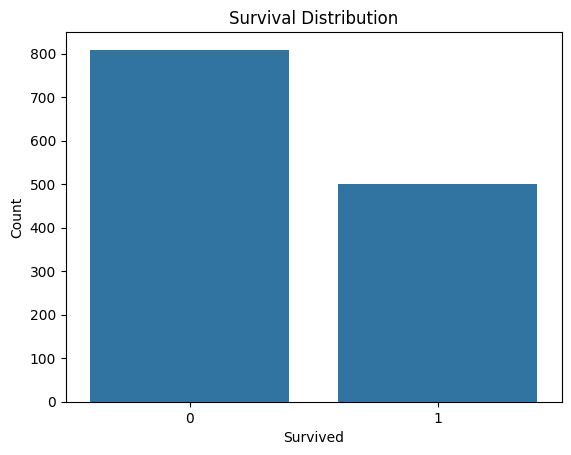

In [148]:
survival_distribution = df['survived'].value_counts()
print("Survival Distribution:")
print(survival_distribution)
sns.countplot(x='survived', data=df)
plt.title("Survival Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

the results show that the data is quite unbalanced. I will later think about oversampling or undersampling

In [149]:
print(df.dtypes)

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object


i then wanted to check what data types I will be working with. The results are 64 bit signed integers, floats and objects.

In [150]:
print(df.columns)

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


before plotting any graph, I needed to know what the columns were named to make sure I wouldn't get errors from capital letters or misspelling

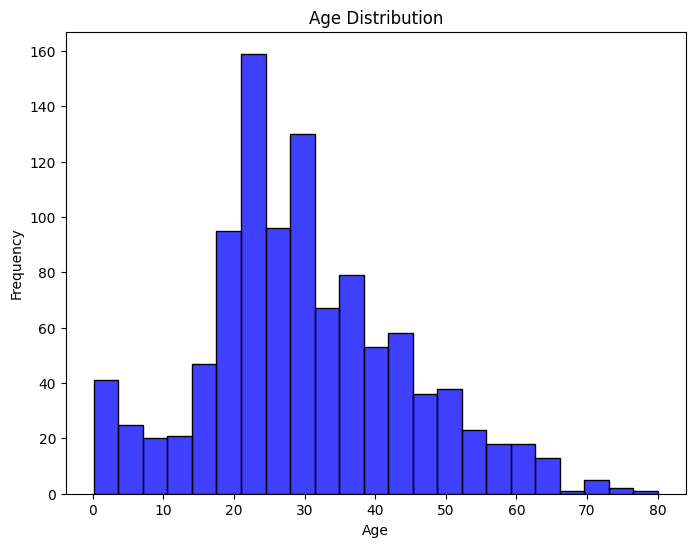

In [151]:
plt.figure(figsize=(8, 6))
sns.histplot(df['age'].dropna(), color='blue')  # Dropping NaN values from 'age'
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


I tried to plot everything I could. I have not worked with a dataset like this many times
so I was anxious to make sure I understood it fully, hence the maybe exagerrated
plotting of graphs!(at least now I know how to plot them)The age distribution has a peak at 20-30, which relates to the mean found before

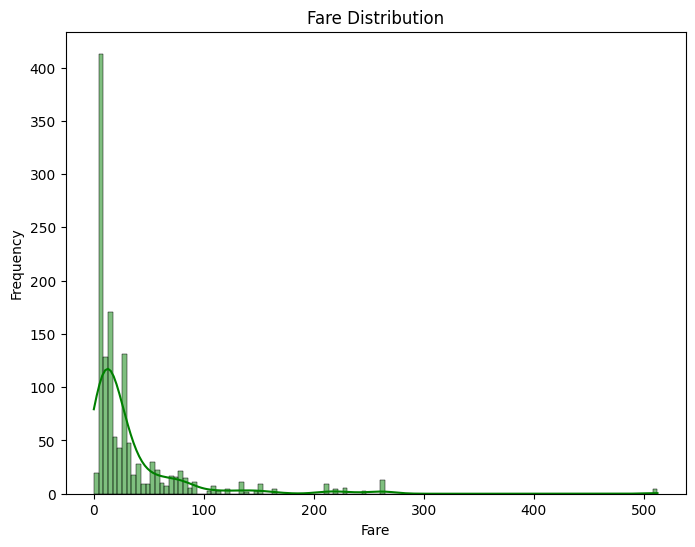

In [152]:
plt.figure(figsize=(8, 6))
sns.histplot(df['fare'].dropna(), kde=True, color='green')  # I dropped all NaN values
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

the fare price is depicted below as a frequency graph. I thought this could be relevant as the best rooms/seats cost more in general so maybe the higher the fare the higher chance of survival

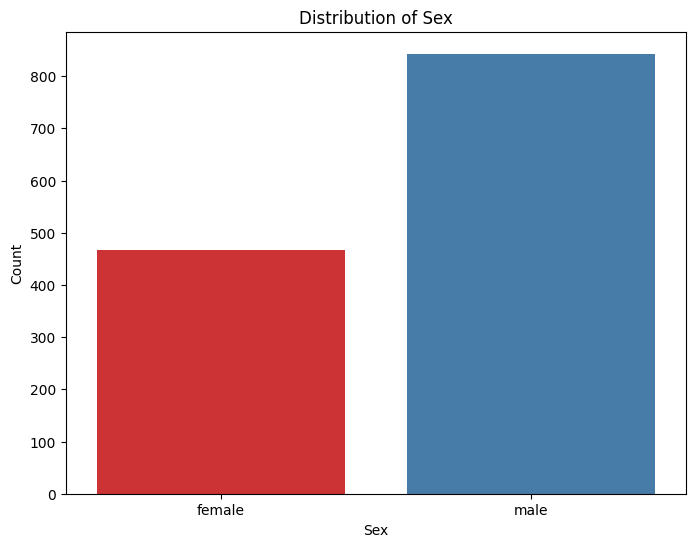

In [153]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=df, hue='sex', palette='Set1')  # Set hue to 'sex'
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


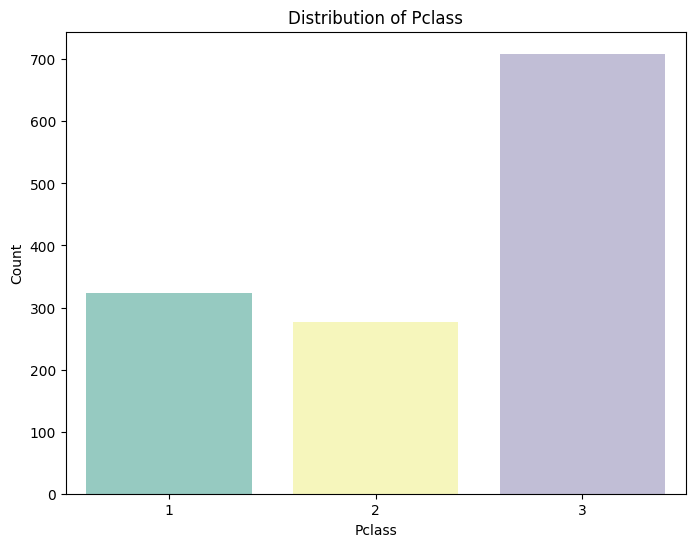

In [154]:
plt.figure(figsize=(8, 6))
sns.countplot(x='pclass', data=df, palette='Set3', hue='pclass', legend=False)  
plt.title('Distribution of Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

as with the fare, maybe this has importance as the more expensive the class, the safer the ride. it could correlate with the chances of survival

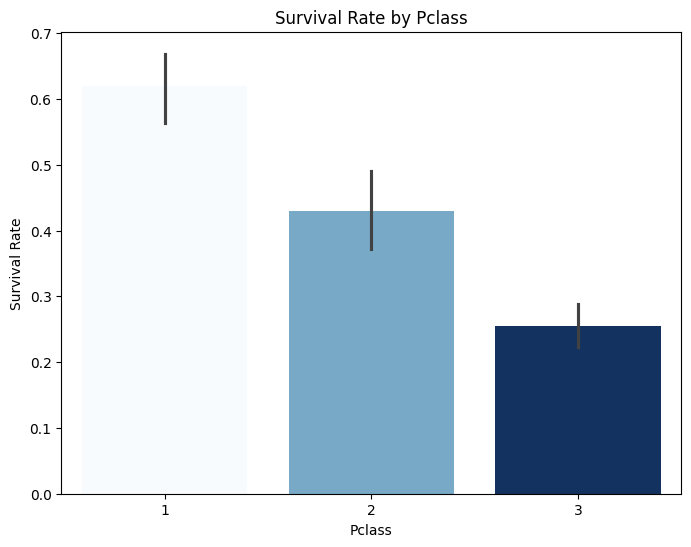

In [155]:
plt.figure(figsize=(8, 6))
sns.barplot(x='pclass', y='survived', data=df, hue='pclass', palette='Blues', legend=False)
plt.title('Survival Rate by Pclass')
plt.xlabel('Pclass')
plt.ylabel('Survival Rate')
plt.show()

as I grew too curious again, I plotted this graph right away, in hopes of seeing a nice correlation between
the class and the survival rate. I was not disappointed. The survival rate lowers as the class cost lowers. 
The most interesting thing for me is how steady the fall is in survival from the first class onwards. 
They are parted almost perfectly 

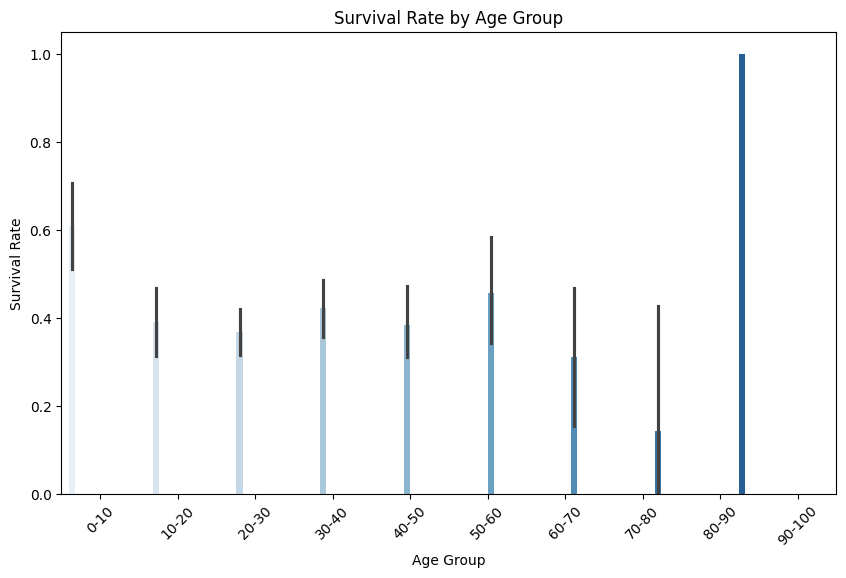

In [156]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='survived', data=df, hue='age_group', palette='Blues', legend=False)
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()


this is the survival rate by age, which should show a pretty strong correlation however the results are not what was expected at all. 
I am amazed at the survival rate of 90 year olds compared to 20 year olds.This is a clear representation of how incorrect or missing data
affects a model and future predictions. I believe this is because of how much data there is for every age group. There was probably only a couple of data points for the 90 year olds, making the age group quite unreliable.

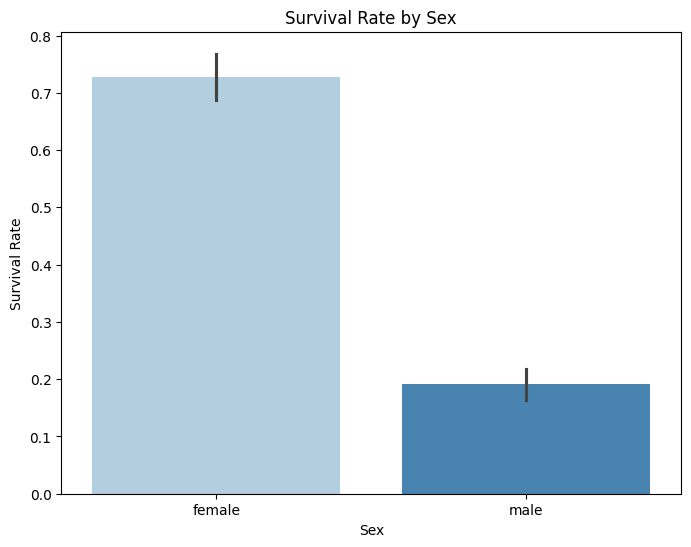

In [157]:
plt.figure(figsize=(8, 6))
sns.barplot(x='sex', y='survived', data=df, hue='sex', palette='Blues', legend=False)
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

as a woman myself, I of course sided with one team in particular during this graph plot. Once again, I was not disappointed!
However, on a more serious note, the major difference in survival made me intrigued and motivated to find the reason behind it

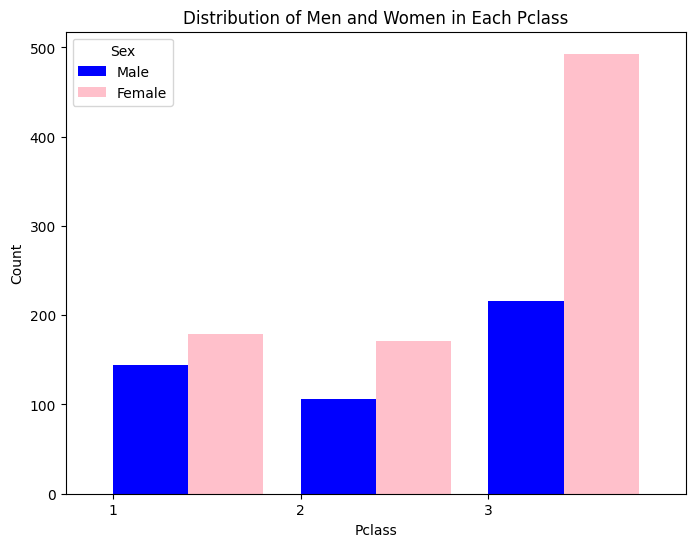

In [158]:
gender_count = df.groupby(['pclass', 'sex']).size().unstack(fill_value=0) #i separated the data into women and men

gender_count.plot(kind='bar', figsize=(8, 6), width=0.8, color=['blue', 'pink'], position=0) 

plt.title('Distribution of Men and Women in Each Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sex', labels=['Male', 'Female'], loc='upper left')
plt.show()

this graph dwells a bit deeper into the survival difference between women and men. My first idea was that the difference in 
survival was this distant because meybe most women were in the first class whereas most men were in the third. However,
it looks as if the men are distributed almost balanced in between classes but most women are in the lowest class. This was a 
very interesting observation for me but made sense because they were meant to let the women and children escape first

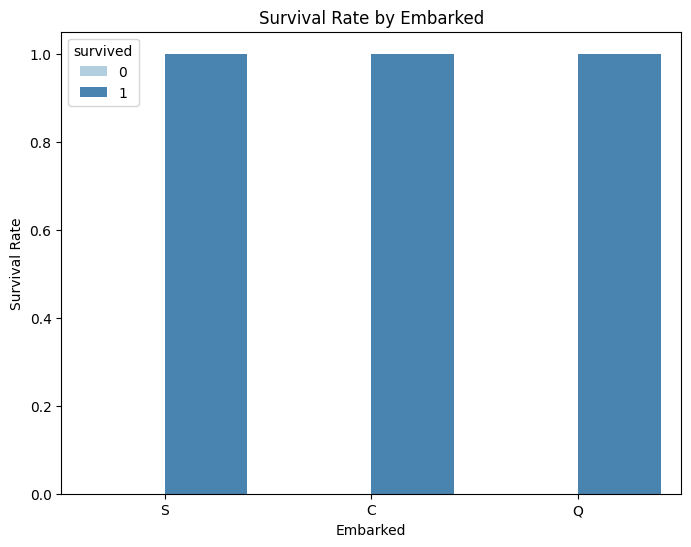

In [159]:
plt.figure(figsize=(8, 6))
sns.barplot(x='embarked', y='survived', data=df, palette='Blues', hue='survived')
plt.title('Survival Rate by Embarked')
plt.xlabel('Embarked')
plt.ylabel('Survival Rate')
plt.show()

I thought survival rate could have something to do with where the people embarked from, although I think it is kind of a big
stretch. I think the difference is due to chance

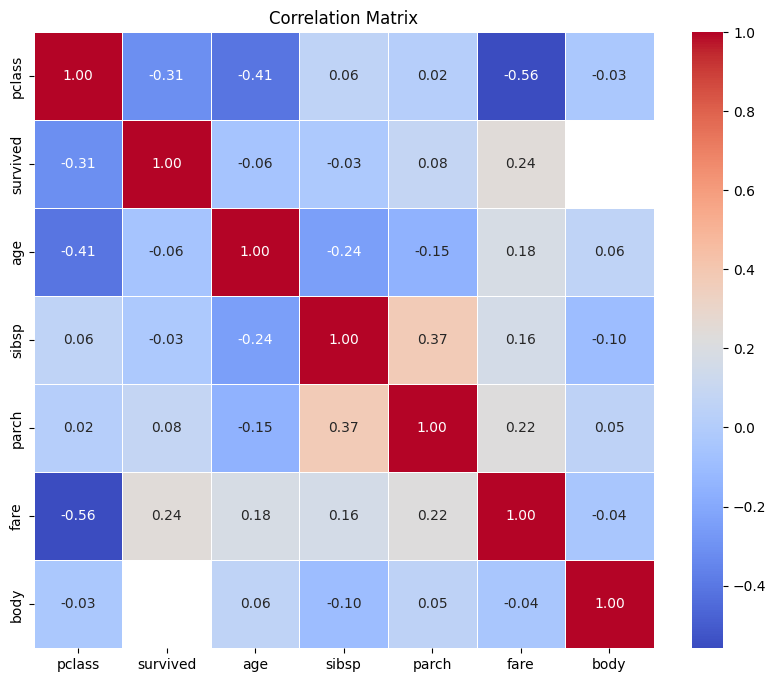

In [160]:
numeric_cols = df.select_dtypes(include=['number']).columns #i only selected the numerical columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

I plotted a correlation matrix. I asked ChatGPT how else I could see correlations between different columns and it
suggested a correlation matrix, so here it is. 
From the matrix we can see that the column that correlates with survival the most is the class the individual travelled in

##  Managing Missing Values and Data Splitting

In [161]:
missing_data = df.isnull().sum()
print(missing_data)

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
age_group     263
dtype: int64


 There is quite a lot of missing data, 
especially for age, which is quite an important predictor for survival

In [162]:
irrelevant_columns = ['age_group', 'body', 'home.dest', 'name', 'ticket', 'boat', 'cabin']
df_cleaned = df.drop(columns=irrelevant_columns)

print(df_cleaned.columns)


Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')


i then proceeded to drop the columns that I believed were mostly irrelevant to the prediction of survival, so I dropped age groups, body, destination, name, ticket, boat and cabin. I then printed the columns that were left to make sure that the code did what it was supposed to.

In [163]:
missing_data_cleaned = df_cleaned.isnull().sum()
print(missing_data_cleaned)

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64


This piece of code checks the missing data that remained, to see what I was working with exactly. 

## Data Splitting

In [164]:
X_train, X_others, y_train, y_others = train_test_split(
    df_cleaned.drop('survived', axis=1),  
    df_cleaned['survived'],               
    test_size=0.3,                        
    stratify=df_cleaned['survived'],      
    random_state=42                       
)

X_val, X_test, y_val, y_test = train_test_split(
    X_others,  
    y_others, 
    test_size=0.5,  # 50% for validation and 50% for testing
    stratify=y_others,  
    random_state=42  
)




print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 916 samples
Validation set size: 196 samples
Test set size: 197 samples


I split the dataset in a stratified manner. I first split the data into 'trained' and 'other', as instructed in the document given. Then Iused the 'other' set to split it into validation and test sets evenly. I stratified by the 'survived' column to make sure that the ratio of survivors and non-survivors is the same in all sets. I am not lwft with x and y for all sets ( training, validation, test). I used x_others as features and y_others as target and features 
X represents the set of input variables used to predict or explain the target variable. 
y is the target variable that the model is trying to predict.

## Inputing missing values

In [165]:
numerical_cols = ['age', 'fare']
categorical_cols = ['embarked']
numerical_imputer = SimpleImputer(strategy='mean')

X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])

X_val[numerical_cols] = numerical_imputer.transform(X_val[numerical_cols])
X_test[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')

X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])

X_val[categorical_cols] = categorical_imputer.transform(X_val[categorical_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

print(X_train.isnull().sum())

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


For inputing missing values I first inputed the columns that would require inputation. I used the mean for the numerical columns and the mode for the categorical columns. I then transformed the validation and test sets with the statistics learned from the training set. Lastly, I checked if there are any missing values left. I chose to input only in the training set at first because I did not want data leakage into my test and validation sets. I know that if i input the mean or mode directly into every set, the model will start to learn from that data as well and the data will get seen by the model, deeming it not good for later testing and validation.
I chose to use the mean for the numerical columns because it is the average of the data and is a good representation of the overall trends. I am aware that both age and fare are quite skewed, but I thought I would try this method at first, and based on my results, I could polish my data. I also chose to use the mode for the categorical column because it is the most frequent value in the data. 

## One-Hot Encoder

In [166]:

X_train['sex'] = X_train['sex'].fillna(X_train['sex'].mode()[0])
X_train['embarked'] = X_train['embarked'].fillna(X_train['embarked'].mode()[0])

# I used the values from the training set to change the missing values in the other sets, to avoid data leakage
X_val['sex'] = X_val['sex'].fillna(X_train['sex'].mode()[0])
X_val['embarked'] = X_val['embarked'].fillna(X_train['embarked'].mode()[0])
X_test['sex'] = X_test['sex'].fillna(X_train['sex'].mode()[0])
X_test['embarked'] = X_test['embarked'].fillna(X_train['embarked'].mode()[0])

# I also verified that I have no missing values left
print(X_train.isna().sum()) 
print(X_val.isna().sum())   
print(X_test.isna().sum())   





# I applied the one-hot encoder to the training, validation and test sets
X_train = pd.get_dummies(X_train, drop_first=True)  
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)


pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


I struggled qite a lot with the one hot encoder, as I would always get an array of missing values after running it. To ensure this would not happen anymore, I decided to change the missing values to the mode once again, as I realized I did not properly deal with all the columns in the first place. Therefore, the first lines of the one-hot encoder are mere data inputations. 

One hot encoder transformed my categorical data into binary values and new columns. This, I presume, will help in the future for machine learning, as the machine wll understand the data way better. Also, one hot encoding I believe avoids the problem where machine learning algorithms might interpret categorical variables as ordinal and make big mistakes. However, I learned that one hot encoder also has a downside. it can make my data more sparse, as for example in embarked there will be many 0 values which makes the information less dense and harder to use to draw conclusions. 

In [167]:
missing_values = X_train.isnull().sum()
print(missing_values)


pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64


In [168]:
X_train['sex_male'] = X_train['sex_male'].fillna(X_train['sex_male'].mode()[0])
X_train['embarked_Q'] = X_train['embarked_Q'].fillna(X_train['embarked_Q'].mode()[0])
X_train['embarked_S'] = X_train['embarked_S'].fillna(X_train['embarked_S'].mode()[0])
'''I filled the missing values with the mode of the column, as it is the most frequent value'''


'I filled the missing values with the mode of the column, as it is the most frequent value'

## Feature scaling

In [169]:
numerical_cols = ['age', 'fare']

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_train_standardized = pd.DataFrame(standard_scaler.fit_transform(X_train[numerical_cols]), columns=numerical_cols)
X_train_normalized = pd.DataFrame(minmax_scaler.fit_transform(X_train[numerical_cols]), columns=numerical_cols)

X_val_standardized = pd.DataFrame(standard_scaler.transform(X_val[numerical_cols]), columns=numerical_cols)
X_test_standardized = pd.DataFrame(standard_scaler.transform(X_test[numerical_cols]), columns=numerical_cols)

X_val_normalized = pd.DataFrame(minmax_scaler.transform(X_val[numerical_cols]), columns=numerical_cols)
X_test_normalized = pd.DataFrame(minmax_scaler.transform(X_test[numerical_cols]), columns=numerical_cols)

X_train_standardized = X_train.drop(numerical_cols, axis=1).join(X_train_standardized)
X_val_standardized = X_val.drop(numerical_cols, axis=1).join(X_val_standardized)
X_test_standardized = X_test.drop(numerical_cols, axis=1).join(X_test_standardized)

X_train_normalized = X_train.drop(numerical_cols, axis=1).join(X_train_normalized)
X_val_normalized = X_val.drop(numerical_cols, axis=1).join(X_val_normalized)
X_test_normalized = X_test.drop(numerical_cols, axis=1).join(X_test_normalized)

print(f"Training set shape (Standardized): {X_train_standardized.shape}")
print(f"Validation set shape (Standardized): {X_val_standardized.shape}")
print(f"Test set shape (Standardized): {X_test_standardized.shape}")

print(f"Training set shape (Normalized): {X_train_normalized.shape}")
print(f"Validation set shape (Normalized): {X_val_normalized.shape}")
print(f"Test set shape (Normalized): {X_test_normalized.shape}")


Training set shape (Standardized): (916, 8)
Validation set shape (Standardized): (196, 8)
Test set shape (Standardized): (197, 8)
Training set shape (Normalized): (916, 8)
Validation set shape (Normalized): (196, 8)
Test set shape (Normalized): (197, 8)


At first I typed the numerical columns and initialized the scalers I would use. I then fit the scalers on the training set ONLY and transformed the validation and test sets using the scalers learned from it. I also checked the shapes of the new data to make sure the data was transformed correctly. I also combined the scaled features with the other columns. 

#### Discuss the differences between standardization and normalization, along with their importance.
Both standardisation and normalisation ensure that all of my features are on a similar scale that is measurable and easily comparable, which can improve the performance and accuracy of  machine learning models.
Standardisation scales the data to have a mean of 0 and a standard deviation of 1. Normalisation scales the data to a range between 0 and 1.
After standardization, the data will surround 0 but it is not sensitive to outliers, unlike normalisation. If there are outliers in the data, from what I learned in probability and statistics as well, they influencethe scaling because the range is determined by the minimum and maximum values, so if I have a max value that is miles away from all other data, it will affect my overall results

## Class Imbalance and SMOTE

In [170]:
# I first want to check the class distribution in the target variable which I named y_train
print(f"Class distribution before SMOTE:\n{y_train.value_counts()}")


Class distribution before SMOTE:
survived
0    566
1    350
Name: count, dtype: int64


In [171]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Class distribution after SMOTE:\n{y_train_resampled.value_counts()}")
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")


Class distribution after SMOTE:
survived
0    566
1    566
Name: count, dtype: int64
X_train_resampled shape: (1132, 8)
y_train_resampled shape: (1132,)


As always, I first initialised the SMOTE object. I then applied it to the training set and checked the class distribution after applying SMOTE. I also checked the shape of the resampled data to make sure they are well aligned.

## Feature Selection

In [172]:
print(X_train.var())  # I check each collumn's variance before VarianceThreshold


pclass           0.707799
age            163.663316
sibsp            0.975611
parch            0.780179
fare          2439.694592
sex_male         0.227221
embarked_Q       0.091320
embarked_S       0.215385
dtype: float64


In [173]:
variance_threshold = VarianceThreshold(threshold=0.1)  

X_train_resampled_selected = variance_threshold.fit_transform(X_train_resampled)
selected_features_variance = X_train_resampled.columns[variance_threshold.get_support()]
print(f"Selected features after variance threshold: {selected_features_variance}")

X_train_resampled_selected_df = pd.DataFrame(X_train_resampled_selected, columns=selected_features_variance)
print(f"X_train_resampled_selected_df shape: {X_train_resampled_selected_df.shape}")


Selected features after variance threshold: Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_S'], dtype='object')
X_train_resampled_selected_df shape: (1132, 7)


I found it quite a challenge to find a threshold that was right for my data. I first triend 0.01, but felt that to be too restraining on my data and what I would delete, so I then tried 0.05 and ultimately landed on 0.1. I think this is a good threshold because it is not too strict and not too lenient at the same time. I then applied the treshold to the training data that I just resampled and tried dropping the features with lower variance. I then checked the features that remained after selection and the shape of my data. 

In [174]:
selector = VarianceThreshold(threshold=0.1) 
X_train_selected = selector.fit_transform(X_train)
X_train_selected_df = pd.DataFrame(X_train_selected, columns=['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_S'])

correlation_matrix = X_train_selected_df.corr().abs()
threshold = 0.9

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print(f"Features dropped?: {high_correlation_features}")

X_train_selected_df = X_train_selected_df.drop(columns=high_correlation_features)
print(f"Number of features after threshold?: {X_train_selected_df.shape[1]}")


Features dropped?: []
Number of features after threshold?: 7


Highly correlated features can cause multicollinearity, which can influence negatuvely the model’s ability to identify true relationships.For correlation, I calculated a correlation matrix and set a correlation treshold of 0.9. I again did not know how to properly choose a good correlation threshold, so I asked chatgpt and tried looking through the slides provided from class. I found 0.9 to be quite fitting for what I needed. I then found the features above that threshold, whoch were the ones placed in the upper side of the triangle of the matrix, and the features that are highly correlatred by looking column by column and comparing. I removed the highly correlated features and printed the information about what was dropped and how many features remained. however, I did not remove any features from the data. I still can not tell if that is good or very bad!

#### Why do we carry out tasks 6 and 7 after splitting the dataset into training, validation, and test sets? Could we have conducted them on the entire dataset instead? 

Features with low variance don't help in comparisons or in predicting the target variable, in this case survival. These features can introduce noise in the model and might ever influence overall model performance by making it more complex and full of unuseful data. Moreover, they can also increase computational cost unnecessarily. By having more data, it takes more time to compute them, but if the data is unusable or irrelevant, the time for computation is wasted on nothing. 
I believe removing features with low variance and high correlation is done after splitting to keep the data intact and not cause data leaks. If I would remove these before splitting, the model would see all the data and the prediction would not be true as it would not get tested against fully unseen information. By removing them after splitting, I ensure I keep the data intact and ensure the model is tested against unseen data, no data leaks happen and I overall have a better chance at not overfitting. Therefore no, eliminating features on the entire datasetinstead would result in biases and test set contaminations, making the whole point of splitting the data useless. 

## Logistic Regression Model


Validation Accuracy: 0.8265
Test Accuracy: 0.7817


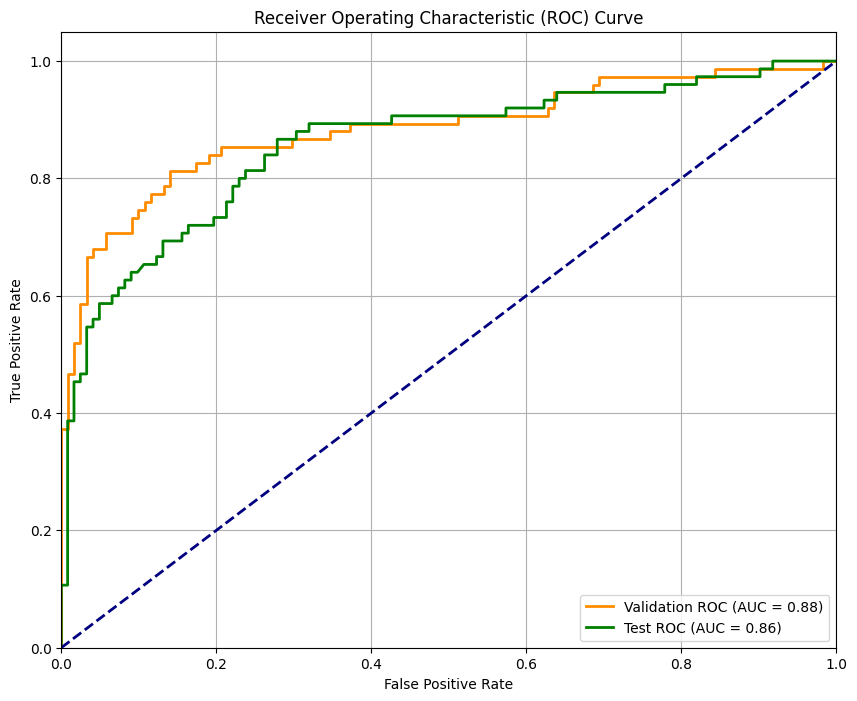

In [175]:
y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred_binary)
test_accuracy = accuracy_score(y_test, y_test_pred_binary)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'Validation ROC (AUC = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
